In [13]:
import pennylane as qml
from pennylane import numpy as np

A = np.array([[1.,1.],
              [4.,2.]])

b = np.array([30., 120.])

In [14]:
# Normalizamos b

norm_b = np.sqrt(sum(b**2))
new_b = b / norm_b
new_b

tensor([0.24253563, 0.9701425 ], requires_grad=True)

In [15]:
# Descomponemos A

# A = 3/2 I - 1/2 Z + 5/2 X -3/2 ZX

cs = np.array([3/2, -1/2, 5/2, -3/2])

def A1(wires):
    qml.Identity(wires = wires)
    
def A2(wires):
    qml.PauliZ(wires = wires)
    
def A3(wires):
    qml.PauliX(wires = wires)
    
def A4(wires):
    qml.PauliX(wires = wires)
    qml.PauliZ(wires = wires)
    
As = [A1, A2, A3, A4]

sol = np.zeros([2,2], dtype = np.complex64)

for ci, Ai in zip(cs, As):
    sol += ci * qml.matrix(Ai)(0)
    
sol

tensor([[1.+0.j, 1.+0.j],
        [4.+0.j, 2.+0.j]], dtype=complex64, requires_grad=True)

In [16]:
# Definimos U tal que U|0> = |b>
# RY|0> = cos(theta/2)|0> + sin(theta/2)|1>

def U(wires):
    qml.RY(2 * np.arccos(new_b[0]), wires = wires)
    

In [17]:
# Definimos V tal que V(theta)|0> = |x>

def V(theta, wires):
    qml.RY(theta, wires = wires)

Definimos la formula de error como:

$$
2 - 2\frac{\sum_{i,j}c_ic_j^*\langle 0|V^{\dagger}A_j^{\dagger}U|0\rangle\langle 0|U^{\dagger}A_iV|0\rangle}{\sum_{i,j}c_ic_j^*\langle 0|V^{\dagger}A_j^{\dagger}A_iV|0\rangle}
$$

In [18]:
# En este caso para la formula no hace falta preocuparse por 
# que salgan números complejos así que será suficiente el 
# Hadamard test que coge parte real.

dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def h_test(op):
    qml.Hadamard(wires = 0)
    qml.ctrl(op, control = 0)(wires = 1)
    qml.Hadamard(wires = 0)
    return qml.expval(qml.PauliZ(0))


In [19]:
# Calculamos el error con la fórmula

def norm_A(theta):
    
    norm = 0
    
    for i in range(len(cs)):
        for j in range(len(cs)):
                   
            def op(wires):
                V(theta, wires = wires)
                As[i](wires = wires)
                qml.adjoint(As[j])(wires = wires)
                qml.adjoint(V)(theta, wires = wires)
                
                
            norm += cs[i] * cs[j] * h_test(op)
            
    return norm
    
def error(theta):
    
    num = 0
    
    for i in range(len(cs)):
        for j in range(len(cs)):
               
            
            def op1(wires):
                V(theta, wires = wires)
                As[i](wires = wires)
                qml.adjoint(U)(wires = wires)

            def op2(wires):
                V(theta, wires = wires)
                As[j](wires = wires)
                qml.adjoint(U)(wires = wires)
                
            num += cs[i] * cs[j] * h_test(op1) * h_test(op2)
            
            
    return 2 - 2 * num / norm_A(theta)
 
            
error(2)      

tensor(0.01996854, requires_grad=True)

In [20]:
theta = np.array(2., requires_grad = True)

opt = qml.AdagradOptimizer(stepsize = .5)
err = []
epochs = 20

for epoch in range(epochs):
    
    theta = opt.step(error, theta)
    err.append(error(theta))


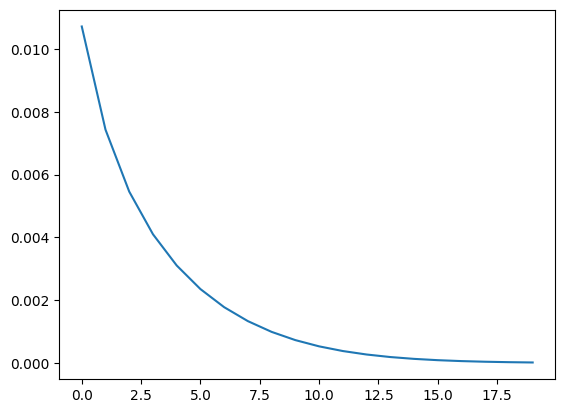

In [21]:
import matplotlib.pyplot as plt

plt.plot(err)

In [22]:
matrix = qml.matrix(V)(theta, wires = 0)
x = np.array([matrix[0,0], matrix[1,0]])
print(x)
x 

[0.99963638+0.j 0.02696511+0.j]


tensor([0.99963638+0.j, 0.02696511+0.j], requires_grad=True)

In [23]:
solution = x * norm_b / np.sqrt(norm_A(theta))
solution = solution.real

In [24]:
print(f"{round(float(solution[0]))} vacas y {round(float(solution[1]))} gallinas")

30 vacas y 1 gallinas
